In [1]:
from IPython.display import Image
from IPython.core.display import HTML

import os, sys

In [2]:
memory_hierarchy = "http://computerscience.chemeketa.edu/cs160Reader/_images/Memory-Hierarchy.jpg"
python_memory = "https://hsto.org/getpro/habr/upload_files/e7f/514/64c/e7f51464c6998b75f4f3fa2bfe0bb5ef"
python_object = "https://hsto.org/getpro/habr/upload_files/a85/7a7/931/a857a7931fb99025933c69a721720680"

# 1. Представление памяти внутри ПК

В большинстве современных ПК используется следующая иерархия памяти: 

In [ ]:
Image(url=memory_hierarchy, width=700, height=600)

| Тип  | Скорость доступа, тактов  | Размер |
|:------------- |:---------------:| -------------:|
| Регистры процессора  | 1 |     ~ 100-1000 байт |
| Кэш L1      | несколько тактов        |         10-100 килобайт   |
| Кэш L2 | десятки тактов        |        500+ килобайт |
| Кэш L3 | ~100        |        от нескольких до сотен мегабайт|
| Кэш L4 | несколько сотен        |        несколько сотен мегабайт|
| ОЗУ | от сотен до нескольких тысяч        |        от нескольких гигабайт до нескольких терабайт|
| Дисковое хранилище | сотни тысяч - миллионы        |        от десятков гигабайт|

# 2. Представление памяти в Python

В отличие от C-подобных языков, при программировании на Python работа с памятью возлагается на интерпретатор. Для управления памятью используется специальный механизм - **аллокатор**. Аллокатор необходим для резервирования у операционной системы (ОС) пространства памяти с целью исключения частого обращения к ОС.

Аллокатор устроен следующим образом:

In [ ]:
Image(url=python_memory, width=600, height=600)

1. **Арена** — большой непрерывный кусок памяти (обычно 256 килобайт), содержит несколько страниц виртуальной памяти операционной системы;

2. **Пул** — одна страница виртуальной памяти (обычно 4 килобайта);

3. **Блок** — небольшой фрагмент памяти, используемый для хранения одного объекта (от 16 до 512 байт).

### Особенности

- Арены включены в двусвязный список и располагаются в порядке увеличения в них свободного пространства;
- Пулы предназначены для хранения блоков одинакового размера;
- Пул может находиться в одном из 3-х состояний: **empty**, **used**, **full**;
- Блок может находиться в одном из 3-х состояний: **untouched**, **free**, **allocated**; 
- Для больших объектов (больше 512 байт) память выделяется непосредственно у ОС.

# 3. Время жизни объекта

Время жизни объекта в Python зависит от **счётчика ссылок** и **механизма сборки мусора**.

## 3.1. Счётчик ссылок

In [ ]:
Image(url=python_object, width=700, height=600)

Каждый объект в **Python** наследуется от базового класса **PyObject**, который содержит поля:

- **ob_type** - указатель на другой объект, тип данного объекта;
- **ob_refcnt** - количество ссылок на объект.

Текущее количество ссылок на объект можно получить при помощи метода **sys.getrefcount(object)**.

### 3.1.1. Случаи, в которых количество ссылок увеличивается:

1. Создание объекта

In [ ]:
a = []
sys.getrefcount(a)

**Примечание:** количество ссылок на созданный объект равно **2**, поскольку объект является аргументом метода **getrefcount**.

2. Присвоение другому объекту

In [ ]:
b = a
sys.getrefcount(a)

3. Объект передаётся в качестве аргумента функции

In [ ]:
def func(lst: list):
    return sys.getrefcount(a)

func(a)

4. Объект сохраняется в контейнере в качестве элемента

In [ ]:
n = [a, a, a]
sys.getrefcount(a)

### 3.1.2. Случаи, в которых количество ссылок уменьшается:

1. Явное удаление объекта

In [ ]:
a = []
sys.getrefcount(a)

In [ ]:
del a

In [ ]:
sys.getrefcount(a)

2. Присвоение нового значения

In [ ]:
a = set()
sys.getrefcount(a)

3. Объект покидает область своего применения, например, при выходе из локальной области видимости

In [ ]:
def func(s: set):
    print('refcount внутри функции:', sys.getrefcount(s))
    

func(a)
print('refcount вне функции:', sys.getrefcount(a))

4. Контейнер, в котором находится объект, уничтожается, либо объект удаляется из контейнера

In [ ]:
n = [a, a, a]
sys.getrefcount(a)

In [ ]:
del n
sys.getrefcount(a)

#### Недостаток механизма подсчёта ссылок - циклические ссылки

Кольцевая зависимость появляется, когда объект A содержит ссылку на объект B, а объект B, в свою очередь, ссылается на объект A. В таком случае, даже если никто больше не ссылается на объекты A и B, счётчик их ссылок никогда не станет равным нулю, а объекты никогда не удалятся.

In [ ]:
a = []
a.append(a)
sys.getrefcount(a)

## 3.2. Механизм сборки мусора (Garbage collector)

Сборщик мусора отслеживает объекты, которые могут содержать ссылки на другие объекты, и рассматривает их доступность из основного кода на Python. При недоступности объекта он подлежит удалению.

Механизм сборки мусора не работает постоянно, а также разделён на **3** поколения.

Каждый новый объект помещается в младшее **1** поколение. Если в течение итерации по сборке мусора объект не подлежит удалению, он перемещается во **2** поколение, сборщик мусора для которого запускается реже, чем для поколения **1**. Аналогичным образом поколение **2** отличается от поколения **3**, в котором содержатся самые *долгоживущие* объекты.

Каждое поколения сборщика мусора содержит следующие параметры:
- индивидуальный счётчик (разность между количеством созданных и удалённых объектов с момента последнего сбора);
- пороговое значение (при превышении счётчиком порогового значения инициируется процесс сборки мусора).



Импортирование модуля, содержащего сборщик мусора:

In [ ]:
import gc

Выключить / включить сборщик мусора:

In [ ]:
gc.disable()
gc.enable()

Ручной запуск:

In [ ]:
gc.collect()

Значения текущих порогов для каждого поколения:

In [ ]:
gc.get_threshold()

Пороги можно изменять:

In [ ]:
gc.set_threshold(150, 10, 10)
gc.get_threshold()

Возвращает текущее количество объектов, подлежащих удалению:

In [ ]:
gc.get_count()

# 4. Объекты Python и занимаемая память

Существует встроенный метод **getsizeof** модуля **sys** для оценки памяти, потребляемой объектом:

In [ ]:
lst = [1, 2, 3, 4, 5]

In [ ]:
sys.getsizeof(lst)

Недостаток **getsizeof** - метод учитывает затраты только на те элементы, которые содержатся в объекте, но не на сам объект.

In [ ]:
from pympler import asizeof

In [ ]:
asizeof.asizeof(lst)

In [ ]:
print('none', sys.getsizeof(None), asizeof.asizeof(None))
print('int', sys.getsizeof(1), asizeof.asizeof(1))
print('float', sys.getsizeof(1.23), asizeof.asizeof(1.23))
print('empty str', sys.getsizeof(""), asizeof.asizeof(""))
print('str', sys.getsizeof("abcdefghijk"), asizeof.asizeof("abcdefghijk"))
print('tuple', sys.getsizeof((1, 2, 3)), asizeof.asizeof((1, 2, 3)))
print('list', sys.getsizeof([1, 2, 3]), asizeof.asizeof([1, 2, 3]))
print('set', sys.getsizeof({1, 2, 3}), asizeof.asizeof({1, 2, 3}))
print('dict', sys.getsizeof({1: None, 2: None, 3: None}), asizeof.asizeof({1: None, 2: None, 3: None}))

**Примечание:** 

- целые числа от **-5** до **256** предсозданы;

# 5. Профайлеры памяти

In [ ]:
import random
from memprof import memprof
from typing import List, Tuple


@memprof
def test_func(numbers: List[int]) -> Tuple[int, list, list]:
    summary = sum(numbers)
    list_to_db = [{'num': num} for num in numbers]
    num_to_str = [str(num) for num in numbers]
    return summary, list_to_db, num_to_str


data = [random.randint(1,100) for i in range(100000)]
result = test_func(data)

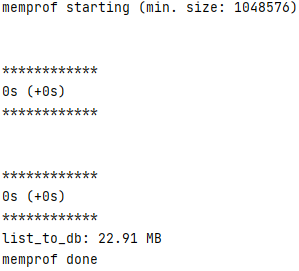

In [ ]:
# pip install psutil memory_profiler
import random
from memory_profiler import profile
from typing import List, Tuple


@profile
def test_func(numbers: List[int]) -> Tuple[int, list, list]:
    summary = sum(numbers)
    list_to_db = [{'num': num} for num in numbers]
    num_to_str = [str(num) for num in numbers]
    return summary, list_to_db, num_to_str


data = [random.randint(1,100) for i in range(100000)]
result = test_func(data)

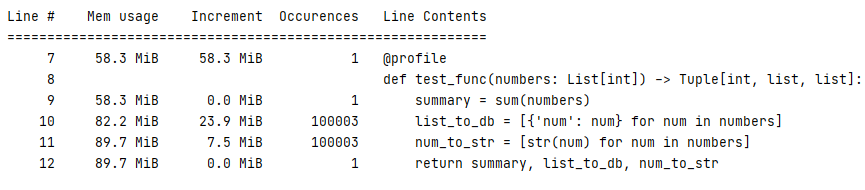

# 6. Рекомендации

- Обращайте внимание на работу с неизменяемыми объектами. К примеру, вместо использования оператора + для соединения строк используйте методы .join(), .format() или f-строки.
- Избегайте вложенных циклов. Создание сложных вложенных циклов приводит к генерации чрезмерно большого количества объектов, занимающих значительную часть виртуальной памяти. Большинство задач, решаемых с помощью вложенных циклов, разрешимы методами модуля **itertools**.
- Используйте кэширование. Если вы знаете, что функция или класс используют или генерируют набор однотипных объектов, применяйте кэширование. Часто для этого достаточно добавить всего лишь один декоратор из библиотеки **functools**.
- Профилируйте код.

# Полезные ссылки

- https://habr.com/ru/company/mailru/blog/336156/

- https://habr.com/ru/company/mailru/blog/336156/

- https://proglib.io/p/pomnit-vse-kak-rabotaet-pamyat-v-python-2021-03-14

- https://stackify.com/python-garbage-collection/

- https://pypi.org/project/memory-profiler/